# Predicting Cause of Death Based on Age at Death and Occupation

Tutorial by Christian Naylor

## Introduction:

One day you will die and be forgotten. Unless of course you are a celebrity in which case your career, legacy, and even your cause of death (no matter how embarrassing) will remain on the internet for all to see for many years to come. 

Thanks to the website who2.com's "<a href="https://www.who2.com/celebrities-listed-by-age-of-death/">Famous people by age of death</a>" list I was able to scrape a list of dead "famous people" (which happened to include a few famous animals), their ages at death, and what they were famous. I intend to use this data to determine the average age at death per occupation along with the rates at which the average age of death increases/decreases over time. This will serve to show whether or not celebrities are representitive of the general population. I expect the average age of death to increase at about the same rate that the <a href="https://ourworldindata.org/life-expectancy">average global life expectancy</a> increases as famous people are still people too. I do think certain categories will not increase at this rate, but overall I believe the general rate will. I may end up comparing the celebrity lifespans to the United States' average lifespan instead of global. As celebrities are generally from the developed world, it might not be accurate to compare them against the entire human population. I will make this decision based on what the celebrity data ends up looking like.

Additionally, I intend to build a predictive model that will guess occupation based on an inputted year of death and age at death. This model is not expected to be accurate as a person's career is choice is not based on their death. However, it will be able to serve as an example for how a predictive model could be built.

## Part 1: Data Collection

To start we will need to import the necessary libraries:
1. <a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/">BeautifulSoup</a> is a webscraping toolkit which allows us to easily break apart and parse the webpages we import. 
2. Both requests and urllib.parse are both tools that help us turn a webpage's html code into useable data. They appear minimally, for a single function or two. 
3. The <a href="https://docs.python.org/3/library/re.html">re (regular expressions)</a> library is also a parse tool allows us to search text for specific strings.
4. <a href="https://numpy.org/doc/stable/">Numpy</a> and <a href="https://pandas.pydata.org/docs/">Pandas</a> are both python libraries used for managing data once it has been imported. They both allow for data manipulation which is crucial as imported data is rarely perfectly formatted by default.
5. <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html">Matplotlib</a> is used for creating the plots that will be used to display the data in an easy to understand way.

In [152]:
# Import the necessary libraries 
from bs4 import BeautifulSoup as bs
import requests as reqs
from urllib.parse import urlparse
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Imports libraries needed for linear regression
from sklearn import linear_model
from scipy import stats

By default, an entire <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html">pandas DataFrame</a> is not usually displayed when the DataFrame exceeds a certain length. This is an asthetic choice as DataFrame's can get very large and repeatedly displaying the entire thing can get messy. The below overrides this default as there are times when I need to be able to see the entire DataFrame I am working with.

In [153]:
# Formatting to show entire DataFrame instead of default
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Initially an error was returned when attempting to pull the desired webpages. This was due to the webpages rejecting the <a href="https://www.w3schools.com/PYTHON/ref_requests_get.asp">GET</a> requests. The below 'headers' variable is just a copy and pasted <a href="https://www.tutorialspoint.com/requests/requests_http_requests_headers.htm">header</a> from a browser (Chrome) taken while visting a webpage. While I am not 100% positive, I believe this tricks the webpage into believing we are a browser pulling the webpage to display as opposed to a python script pulling the webpage for whatever purpose a python script might have.

In [154]:
# Website initially denied get requests so we need a 'headers' variable
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}

Since the oldest age provided by who2.com is 106, I create a couple of arrays indexed from 0 t 106 to hold the pulled webpages. As not every age is represented (for example there are not famous people who died at ages 0, 1, 2, 8, or 9) we do not necessarily <i>need</i> the arrays to be this length. However, it would get annoyingly complicated and difficult to work with if we only had the exact number of needed indexes. I instead opt to use the below, having empty (None) values in the indexes that represent age groups with no one in them.

In [155]:
# Creates two arrays
page = [None] * 107
raw = [None] * 107

As stated above, the data was gathered from who2.com's list of "<a href="https://www.who2.com/celebrities-listed-by-age-of-death/">Famous people by age of death</a>". This list is not located on a single webpage, rather every age group has its own webpage. Luckily, each webpage has a URL that only differs from the others in a single way, the age of the group represented. Consequently, a loop can be created that iterates from 3 (the lowest age at which a famous "person" died) and 106 (the highest). The loop then adjusts the URL string accordingly as well as iterates through the two arrays, storing the imported text.

In [156]:
for age in range(3,107):
    # Changes the URL with each iteration
    url = "https://www.who2.com/famous-people-died-at-age-" + str(age) + "-years-old/"
    # Pulls the webpage using the above URL
    page[age] = reqs.get(url, headers=headers)
    # Converts to text
    raw[age] = page[age].text

The above successfully imported the webpages but that's all. As seen below, the webpages are just html text and are consequently incredibly messy and impossible to use.

In [157]:
# Example html
raw[27]

'<!DOCTYPE html>\r\n<!--[if IE 8]> <html lang="en-US" class="ie8"> <![endif]-->\r\n<!--[if !IE]><!--> <html lang="en-US"> <!--<![endif]-->\r\n\r\n<head>\r\n\t<meta name="viewport" content="width=device-width, initial-scale=1"/>\r\n\t<meta charset="UTF-8">\r\n\t<link rel="preload" as="font" href="https://41z6h24c86pu1h3m6x151ecm-wpengine.netdna-ssl.com/wp-content/themes/newsmag/fonts/fontawesome-webfont.woff" type="font/woff2" />\r\n\t<link rel="preconnect" href="https://fonts.gstatic.com">\r\n\t\r\n\r\n\r\n\t<!--[if lt IE 9]>\r\n\t<script src="https://41z6h24c86pu1h3m6x151ecm-wpengine.netdna-ssl.com/wp-content/themes/newsmag/js/html5.js"></script>\r\n\t<![endif]-->\r\n\n\t\t<!-- All in One SEO 4.1.2.1 -->\r\n\t\t<title>Famous People Listed by Age of Death | Who2</title>\n\t\t<meta name="google-site-verification" content="hCMZ-9Mr6AFg1h0MPeA2JL5Bk2UWKOuDc7Jd-2LlRXE" />\n\t\t<meta name="msvalidate.01" content="90DEA6B185867CC9C50DB784568D7B84" />\n\t\t<link rel="canonical" href="https://

This concludes our first step of "Data Collection" as we have successfully imported the our data, granted it is still in html and unusable. The next section will get it into a workable format using regular expressions to parse the webpages and Pandas to create a DataFrame.

## Part 2: Data Managment:

Iterating through each webpage, we use a <a href="https://docs.python.org/3/library/re.html">regular expression</a> to pull out the list of names and occupations of each person within the particular age group. The regular expression used searches for the string: <b>"data-display-name="</b> and captures everything <b>"(.*)"</b> until the next occurance of <b>">"</b>. 

This regular expression was created after <a href="https://www.howtogeek.com/416108/how-to-view-the-html-source-in-google-chrome/#:~:text=View%20Source%20Using%20View%20Page,webpage%2C%20completely%20expanded%20and%20unformatted.">viewing the webpage as html</a> and noticing that before each person's name and occupation there was always that particular string of text. Therefore, searching for that string and collecting everything immediately after it is a good way to collect the list of people from that age group.

This is repeated until the end of the wepage is reached, at which point the loop increments and the next webpage. In instances where there are more than a single person in the age group, that is multiple strings fit the regular expression, an array containing the separate strings is returned. This can be seen in the below example where an array of length 13 is printed, consisting of the members of the infamous "27 Club".

In [478]:
# Creates new array to house the trimmed text
shaved = [None] * 107
for cell in range(3,107):
    # The regex expression finds anything within html list tags, <li>
    shaved[cell] = re.findall("data-display-name=(.*)>", raw[cell])
    
# Displays the result of the regex using the 27 age group as an example
print(len(shaved[27]))
shaved[27]

13


['"Kurt Cobain" data-job="Guitarist"',
 '"John Birch" data-job="Missionary"',
 '"Andreas Lubitz" data-job="Pilot"',
 '"Robert Johnson" data-job="Guitarist"',
 '"Brian Jones" data-job="Guitarist"',
 '"Aaron Hernandez" data-job="Murder Suspect"',
 '"Pat Tillman" data-job="Football Player"',
 '"Jim Morrison" data-job="Rock Musician"',
 '"Joseph Merrick" data-job="Medical Curiosity"',
 '"Janis Joplin" data-job="Singer"',
 '"D. Boon" data-job="Guitarist"',
 '"Jimi Hendrix" data-job="Rock Musician"',
 '"Amy Winehouse" data-job="Songwriter"']

While I could theoretically use numpy here, I choose to use <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html">Pandas DataFrames</a> as I find it to be superior in most ways when using 1-dimensional data.

In [479]:
# Creates DataFrame
full = pd.DataFrame(
    columns = ['Name', 'Occupation'])

While the data in 'shaved' is more managable than it was, it still does not have any meaning that a model could asertain. To break it apart further we use another regular expression to pull out the name and the occupation ("data-job"). The name is found by selecting everything within the first set of quotation marks while the occupation is taken by selecting everything after 'job="' and before the closing quotation mark. These removed strings are then added to the DataFrame created above.

In [480]:
age = 3
# Iterates through every age group
for ageGroup in range(3,107):
    # Iterates through every person in the age group
    for person in shaved[ageGroup]:
        age_oc = re.search("\"(.*)\" .*job=\"(.*)\"", person)
        series_obj = pd.Series([age_oc[1], age_oc[2]], index=full.columns)
        full = full.append(series_obj, ignore_index=True)
    age += 1

In [481]:
# Display example
full.head()

,Name,Occupation
0,Barbaro,Racehorse
1,Germanicus,Military Leader
2,Phar Lap,Racehorse
3,JonBenet Ramsey,Murder Victim
4,Dolly the Sheep,Cloning Subject


I also want the years the individuals died.

In [670]:
#Creates an empty DataFrame with a single column labels 'Year of Death'.
years = pd.DataFrame(
    columns = ['Year of Death'])
# Display the headers of the currently empty DataFrame
years

,Year of Death


Here we iterate through each webpage looking for the years the individuals died. Luckily, each listing has a hyperlink to a webpage consisting of all the people who also died that same year. These links follow identical formats so I can create a regular expression looking for these links and extracting the year from them.

In [671]:
shaved3 = [None] * 107
# Iterates through the webpages
for cell in range(3,107):
    # The regex expression finds anything matching the below string
    shaved3[cell] = re.findall("died-in/(\d+)/", raw[cell])   
# Once again an example using the "27 Club"
shaved3[27]

['1994',
 '1945',
 '2015',
 '1938',
 '1969',
 '2017',
 '2004',
 '1971',
 '1890',
 '1970',
 '1985',
 '1970',
 '2011']

In [672]:
# Iterates through shaved3
for agegroup in shaved3:
    # If agegroup is not empty
    if agegroup != None:
        # Add the years of death to years
        for year in agegroup:
            ser = pd.Series(year, index=years.columns)
            years = years.append(ser, ignore_index=True)

In [673]:
# Example
years.head()

,Year of Death
0,2007
1,19
2,1932
3,1996
4,2003


As can be seen at this <a href="https://www.who2.com/famous-people-died-at-age-3-years-old/">example webpage</a>, every name is followed by the exact age the "person" was when they died. The below regular expression iterates through the webpages a second time, pulling these ages so we can have our models work with the individual's age down to the day instead of just generalizing by year. This will allow the predictions to make guesses to the day as well.

In [486]:
shaved2 = [None] * 107
# Iterates through the webpages
for cell in range(3,107):
    # The regex expression finds anything matching the below string
    shaved2[cell] = re.findall("at (\d+) years (\d+) days", raw[cell])
# Once again an example using the "27 Club"
shaved2[27]

[('27', '44'),
 ('27', '89'),
 ('27', '96'),
 ('27', '100'),
 ('27', '125'),
 ('27', '164'),
 ('27', '168'),
 ('27', '207'),
 ('27', '249'),
 ('27', '258'),
 ('27', '265'),
 ('27', '295'),
 ('27', '312')]

A new DataFrame to hold the ages. This will be concatenated to the above DataFrame.

In [487]:
ages = pd.DataFrame(
    columns = ['Age at Death (Years)', 'Days Since Last Birthday'])
# Display the headers of the currently empty DataFrame
ages

,Age at Death (Years),Days Since Last Birthday


In [488]:
# Iterates through 'shaved2'
for agegroup in shaved2:
    # As long as the age group is not empty
    if agegroup != None:
        # Iterate through each value within the current agegroup
        for cell in agegroup:
            # Turn tuples into Pandas Series
            row = pd.Series([cell[0], cell[1]], index=ages.columns)
            # Append the Series to 'ages'
            ages = ages.append(row, ignore_index=True)
ages.head(5)

,Age at Death (Years),Days Since Last Birthday
0,3,275
1,4,139
2,5,184
3,6,141
4,6,224


Unfortunately, I encountered some errors with the regex I used to pull the ages. There were issues when someone died on their birthday or the day after. When they died on their birthday the text would not include the word "days" and when they died one day after the text would say "a day" instead of "/d days". This caused the list of ages to be shorter than the list of names. To fix this I just dropped all the people who died on their birthday or the day after. I chose to drop, as opposed to adjust the regex, as dropping them will not affect the data as it is quite literally a random sample. This was easier than spending a bunch of time creafting the perfect regular expression just so these 15 people were not lost. All but index 301 below are dropped from 'full' for this reason'.

In [489]:
# Performs drop
full.drop([99,131,220,301,356,595,633,727,887,1106,1138,1385,1501,1502,1638,1711], inplace=True)
# Reset index as there are now rows missing
full = full.reset_index()
# Resetting index added a new column with the old indexes, delete this column
full = full.drop('index', axis=1)

There was another error, this time with the regular expression used to gather the year of death for the individual "Virgil" who died in 19 BC. He was consequently dropped above from 'full' (index 301) and in 'ages' (index 298).

In [490]:
# Performs drop
ages.drop([298], inplace=True)
# Reset index as there are now rows missing
ages = ages.reset_index()
# Resetting index added a new column with the old indexes, delete this column
ages = ages.drop('index', axis=1)

The same indexes that were dropped from 'full' due to the issues pulling the ages at death are dropped from 'years'. However, index 301 does not need to be dropped since the value that was supposed to be there is already missing from 'years' (which is why it needed to be dropped from the other two.

In [491]:
# Performs drop
years.drop([99,131,220,356,595,633,727,887,1106,1138,1385,1501,1502,1638,1711], inplace=True)
# Reset index as there are now rows missing
years = years.reset_index()
# Resetting index added a new column with the old indexes, delete this column
years = years.drop('index', axis=1)

Our 3 DataFrames now have identical lengths. After readjusting all the indexes I went through, randomly selecting some rows through the data sets to check. I confirmed that everything aligns perfectly with the website so no errors were made that could shift the data by mistake.

In [492]:
print(len(full))
print(len(ages))
print(len(years))

1748
1748
1748


In [493]:
# Combine all 3 DataFrames into 1
data = pd.concat([full, ages, years], axis=1)

In [494]:
# Example
data.head()

,Name,Occupation,Age at Death (Years),Days Since Last Birthday,Year of Death
0,Barbaro,Racehorse,3,275,2007
1,Germanicus,Military Leader,4,139,19
2,Phar Lap,Racehorse,5,184,1932
3,JonBenet Ramsey,Murder Victim,6,141,1996
4,Dolly the Sheep,Cloning Subject,6,224,2003


In [495]:
# Displays the number of unique "Occupation' values
len(data['Occupation'].unique())

234

Seeing as 234 unique occupations would be difficult to work with, considering that we will need to assign each a numerical value when creating our model, we create a function to generalize occupations. All 234 occupations fall into one of the below 14 categories:
1. Animal: Animals famous enough to transcend species and make the list. (Examples: racehorses, sign-language chimps, cloning subjects)
2. Victims: People famous for how they died. (Examples: murder victims, holocaust victims)
3. Activists: People famous for their activism. (Examples: civil rights leaders, philanthropists)
4. Athletes: People famous for their achievements in sports. (Examples: players, coaches)
5. Musician: People famous for their contributions to music. (Examples: singers, instrumentalists, producers) 
6. War Figure: People famous for their actions during war. (Examples: war figures, revolutionaries, soliders)
7. Criminal: People famous for their crimes. (Examples: assassins, murderers, gangsters, terrorists)
8. Useless Person: People with "careers" I believe are useless (fight me!). (Examples: secret lovers, critics, celebrity relatives, clergymen, internet celebrities)
9. Artist: People famous for their contributions to the arts. (Examples: poets, authors, architects)
10. Government Official: People famous for their roles in government. (Examples: presidents, royalty, popes)
11. Entertainer: People famous for keeping us entertained. (Examples: actors, directors, comedians)
12. Other: People with careers that do not fall into any other category (Examples: folk heros, salesmen, chess players)
13. Scientist: People famous for their contributions to science. (Examples: astronauts, mathmaticians, medical professionals)
14. Academic: People famous for their academic pursuits. (Examples: philosophers, historians, economists)


In [496]:
def jobs(x):
    if x == "Racehorse" or x == "Dog" or x == "Cloning Subject" or x == "Sign-Language Chimp" or x == "Gorilla":
        return "Animal"
    elif x == "Murder Victim" or x == "Beating Victim" or x == "Missing Person" or x == "Holocaust Victim" or x == "Slaying Victim" or x == "Victim of Police Violence":
        return "Victim"
    elif x == "Civil Rights Figure" or x == "Humanitarian" or x == "Philanthropist" or x == "Environmentalist" or x == "Naturalist" or x == "Antislavery Activist" or x == "Peacenik":
        return "Activist"
    elif x == "Luger" or x == "Bodybuilder" or x == "Mountain Climber" or x == "Basketball Coach" or x == "Swimmer" or x == "Bowler" or x == "Jockey" or x == "Gymnast" or x == "Coach" or x == "Figure Skater" or x == "Olympian" or x == "Soccer Player" or x == "Boxer" or x == "Tennis Player" or x == "Auto Racer" or x == "Golfer" or x == "Martial Artist" or x == "Basketball Player" or x == "Pro Wrestler" or x == "Runner" or x == "Football Player" or x == "Baseball Player":
        return "Athlete"
    elif x == "Rock Musician" or x == "Drummer" or x == "Opera Singer" or x == "Country Musician" or x == "Harpist" or x == "Blues Singer" or x == "Soul Musician" or x == "Conductor" or x == "Pianist" or x == "Music Producer" or x == "Trombonist" or x == "Composer" or x == "Saxophonist" or x == "Country Singer" or x == "Pop Musician" or x == "Rapper" or x == "Songwriter" or x == "Singer" or x == "Guitarist" or x == "Jazz Musician":
        return "Musician"
    elif x == "Revolutionary" or x == "World War I Figure" or x == "World War II Figure" or x == "Revolutionary War Figure" or x == "Civil War Figure" or x == "Soldier":
        return "War Figure"
    elif x == "Assassin" or x == "Fugitive" or x == "Crime Suspect" or x == "Murder Suspect" or x == "Convict" or x == "Fraud" or x == "Attempted Assassin" or x == "Murderer" or x == "Outlaw" or x == "Gangster" or x == "Terrorist":
        return "Criminal"
    elif x == "Evangelist" or x == "Nun" or x == "Scandal Figure" or x == "Political Scandal Figure" or x == "Secret Lover" or x == "Critic" or x == "Film Reviewer" or x == "Theologian" or x == "Celebrity Relative" or x == "Political Relative" or x == "Clergyman" or x == "Clergywoman" or x == "Internet Celebrity":
        return "Useless Person"
    elif x == "Poet" or x == "Photog" or x == "Illustrator" or x == "Architect" or x == "Photographer" or x == "Sculptor" or x == "Writer" or x == "Playwright" or x == "Artist" or x == "Humorist":
        return "Artist"
    elif x =="Military Leader" or x == "Pope" or x == "President of Yugoslavia" or x =="Prime Minister of Canada" or x == "Diplomat" or x == "Emperor" or x == "Voice Actor" or x == "President of Egypt" or x == "State Governor" or x == "Prime Minister of Israel" or x == "U.S. Secretary of State" or x == "U.S. First Lady" or x == "President of the Czech Republic" or x == "President of Russia" or x == "President of Mexico" or x == "Presidential Advisor" or x == "Mayor of New York City" or  x == "Prime Minister of Great Britain" or x == "President of Zimbabwe" or x == "U.S. Representative" or x == "Royal Consort" or x == "Royalty" or x == "Prime Minister of Pakistan" or x == "Political Leader" or x == "Ruler" or x == "U.S. Vice President" or x == "U.S. President" or x == "Political Figure" or x == "Religious Figure" or x == "U.S. Senator":
         return "Government Official"
    elif x == "Filmmaker" or x == "Actor" or x == "Orator" or x == "Director" or x == "Editor"  or x == "Financier" or x == "Talk Show Host" or x == "Game Show Host" or x == "Monologuist" or x == "Screenwriter" or x == "Theater Director" or x == "Puppeteer" or x == "Animator" or x == "Radio Personality" or x == "TV Personality" or x == "TV Director" or x == "Movie Cowboy" or x == "Cartoonist" or x == "TV Producer" or x == "Dancer" or x == "Magician" or x == "Business Personality" or x == "Comedian" or x == 'Movie Producer' or x == "Daredevil":
        return "Entertainer"
    elif x == "" or x == "Gunfighter" or x == "Sailor" or x == "Psychiatric Patient" or x == "Auto Designer" or x == "Pollster" or x == "Navigator" or x == "TV Newscaster" or  x == "Speechwriter" or x == "Columnist" or x == "Real Estate Developer" or x == "Corporate Icon" or x == "Pilot" or x == "Spy" or x == "Prognosticator" or x == "Industrialist" or x == "Entrepreneur" or x == "Folk Hero" or x == "Librarian" or x == "Salesman" or x == "Chess Player" or x == "Pinup" or x == "Chef" or x == "Jurist" or x == "Fashion Designer" or x == "Journalist" or x == "Publisher" or x == "Law Officer" or x == "Tall Person"  or x == "Explorer" or x == "Saint" or x == "Intern" or x == "Slave" or x == "Aviator" or x == "Adventurer" or x == "Lawyer" or x == "Missionary" or x == "Medical Curiosity" or x == "Medical Patient" or x == "Model" or str(x) == "nan":
        return "Other"
    elif x == "Astronaut" or x == "Ornithologist" or x == "Lepidopterist" or x == "Physiologist" or x == "Electrical Engineer" or x == "Medical Pathologist" or x == "Psychiatrist" or x == "Seismologist" or x == "Oceanographer" or x == "Surgeon" or x == "Nurse" or x == "Anthropologist" or x == "Bacteriologist" or x == "Botanist" or  x == "Archaeologist" or x == "Ophthalmologist" or x == "Biologist" or x == "Astronomer" or x == "Computer Scientist" or x == "Chemist" or x == "Inventor" or x == "Zoologist" or x == "Scientist" or x == "Physician" or x == "Physicist" or x == "Mathematician" or x == "Engineer":
        return "Scientist"
    elif x == "Educator" or x == "Cartographer" or x == "Lexographer" or x == "Linguist" or x == "Economist" or x == "Philosopher" or x == "Psychologist" or x == "Historian" or x == "Philologist":
        return "Academic"
    # I do not return non-sorted with 'Other' in case a new career is added, I want to know.
    else:
        return x

We now apply our above function to all the occupations, changing them to one of our 14 options.

In [497]:
x = 0
for row in data.iterrows():
    # If x is not one of our generalized options, replace it
    data.iloc[x,1] = jobs(data.iloc[x,1])
    x += 1
data.head()

,Name,Occupation,Age at Death (Years),Days Since Last Birthday,Year of Death
0,Barbaro,Animal,3,275,2007
1,Germanicus,Government Official,4,139,19
2,Phar Lap,Animal,5,184,1932
3,JonBenet Ramsey,Victim,6,141,1996
4,Dolly the Sheep,Animal,6,224,2003


It worked! There are only occupations within our 14 categories.

In [674]:
data['Occupation'].unique()

array(['Animal', 'Government Official', 'Victim', 'Other', 'Activist',
       'Musician', 'Entertainer', 'Athlete', 'War Figure', 'Criminal',
       'Useless Person', 'Artist', 'Scientist', 'Academic'], dtype=object)

We need our ages to be integers, not strings.

In [499]:
# Changes age columns to type int
data['Age at Death (Years)'] = data['Age at Death (Years)'].astype(int)
data['Days Since Last Birthday'] = data['Days Since Last Birthday'].astype(int)
# Calculates the total age in days
data['Age in Days'] = (data['Age at Death (Years)'] * 365) + data['Days Since Last Birthday'] + (data['Age at Death (Years)'] / 4)
# Changes 'Age in Days' to int (instead of float)
data['Age in Days'] = data['Age in Days'].astype(int)
data['Year of Death'] = data['Year of Death'].astype(int)

In [500]:
# Minor formatting, rearranges columns
data = data[['Name', 'Occupation', 'Age at Death (Years)', 'Days Since Last Birthday', 'Age in Days', 'Year of Death']]
data.head()

,Name,Occupation,Age at Death (Years),Days Since Last Birthday,Age in Days,Year of Death
0,Barbaro,Animal,3,275,1370,2007
1,Germanicus,Government Official,4,139,1600,19
2,Phar Lap,Animal,5,184,2010,1932
3,JonBenet Ramsey,Victim,6,141,2332,1996
4,Dolly the Sheep,Animal,6,224,2415,2003


While there were clearly some issues with the regular expressions, considering the data being used was gather from close to 100 unique webpages containing lists of strings (as opposed to data sets), I believe it went relatively well. Any discrepencies were easily identified by cross referencing the DataFrames and fixed before combining the DataFrames into one. 

Now that we have all of the dead celebrities' ages at the time of death and their years of death, let's explore the data to look for potential relationships.

## Part 3: Exploratory Data Analysis

We now have a workable DataFrame consisting of the names, occupations, ages at time of death, and the years the deaths occured. The first thing we can do is see how the occupations compare to one another.

The below simply iterates through the full data set, grouping by occupation.

In [501]:
# Creates an array consisting of the occupation options
occupations = sorted(data['Occupation'].unique())
# A new empty list
DeathsByOcc = []
# Iterates through the types of occupations
for job in occupations:
    # Resets curr to an empty list
    curr = []
    # Iterates through the 'data' DataFrame
    x = 0
    for row in data.iterrows():
        # If current row's 'Occupation' matches the one being searched for
        if data.iloc[x,1] == job:
            # Add it to 'curr'
            curr.append(data.iloc[x,4])
        x += 1
    # Adds 'curr' to 'DeathsByOcc' creating a list of lists
    DeathsByOcc.append(curr)         

Now to plot. We use a violin plot because this will show us the min, max, and mean for every group. It also shows the distrubution so we have a way (other than just the mean) to understand the concentration of the data within each group.

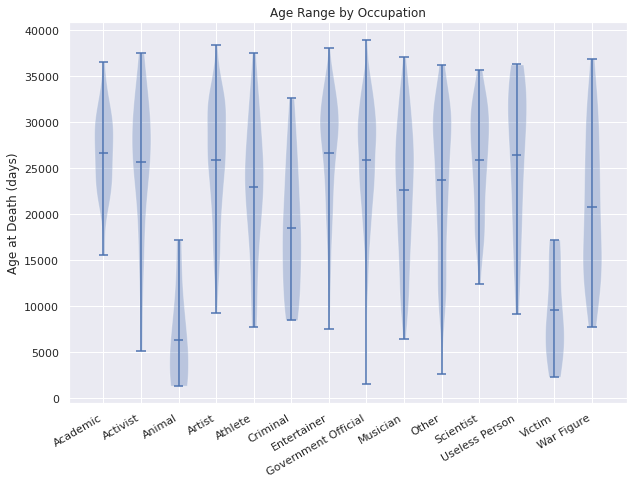

In [502]:
fig, ax = plt.subplots(figsize=(10,7))
# Create a violin plot
dic = ax.violinplot(DeathsByOcc, showmeans=True)
ax.set_ylabel("Age at Death (days)")
ax.set_title("Age Range by Occupation")
# Formatting for x labels
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ax.set_xticklabels(occupations)
plt.xticks(rotation=30, ha='right')
# Display plot
fig.show()

I want to see the mean for each group. I believe violin plot returns a dictionary that allows me to access the mean somehow but I could not find any documentation on how to get the object the means were stored in to display properly so I just built the below. This calculates the mean in days and then uses that value to calculate the mean in years+days. The returned value from the second calculation is then printed for each group so I can compare them.

In [677]:
# Calculates the average life span for each group in both days and years+days
means = []
# Iterats through 'DeathsByOcc'
for occ in DeathsByOcc:
    num = 0
    thesum = 0
    # Gets sum and number of entries
    for value in occ:
        thesum += value
        num += 1
    # Calculates mean
    mean = thesum / num
    mean = int(mean)
    means.append(mean)
means2 = []
# Iterates through means
for mean in means:
    # Age in years
    years = mean / 365
    # Remainder days
    days = mean % 365
    means2.append((years, days))

# Prints out the above
print("        Average Age at Time of Death by Occupation")
print("Academic: " + str(int(means2[0][0])) + " years " + str(means2[0][1]) + " days")
print("Activist: "+ str(int(means2[1][0])) + " years " + str(means2[1][1]) + " days")
print("Animal: "+ str(int(means2[2][0])) + " years " + str(means2[2][1]) + " days")
print("Artist: "+ str(int(means2[3][0])) + " years " + str(means2[3][1]) + " days")
print("Athlete: "+ str(int(means2[4][0])) + " years " + str(means2[4][1]) + " days")
print("Criminal: "+ str(int(means2[5][0])) + " years " + str(means2[5][1]) + " days")
print("Entertainer: "+ str(int(means2[6][0])) + " years " + str(means2[6][1]) + " days")
print("Government Official: "+ str(int(means2[7][0])) + " years " + str(means2[7][1]) + " days")
print("Musician: "+ str(int(means2[8][0])) + " years " + str(means2[8][1]) + " days")
print("Other: "+ str(int(means2[9][0])) + " years " + str(means2[9][1]) + " days")
print("Scientist: "+ str(int(means2[10][0])) + " years " + str(means2[10][1]) + " days")
print("Useless Person: "+ str(int(means2[11][0])) + " years " + str(means2[11][1]) + " days")
print("Victim: "+ str(int(means2[12][0])) + " years " + str(means2[12][1]) + " days")
print("War Figure: "+ str(int(means2[13][0])) + " years " + str(means2[13][1]) + " days")

        Average Age at Time of Death by Occupation
Academic: 73 years 224 days
Activist: 70 years 155 days
Animal: 17 years 121 days
Artist: 71 years 163 days
Athlete: 62 years 277 days
Criminal: 50 years 204 days
Entertainer: 72 years 348 days
Government Official: 73 years 277 days
Musician: 62 years 68 days
Other: 65 years 258 days
Scientist: 72 years 139 days
Useless Person: 74 years 81 days
Victim: 26 years 73 days
War Figure: 59 years 18 days


This is informative. We now have an idea of where each occupation lands relative to the one another, at least in terms of how long one can expect to survive as a member of that career field. 

As could probably be expected, famous animals have the lowest average age at death (17 years 155 days) as they are not humans and therefore have shorter lifespans. Famous victims have the second lowest average (26 years 73 days) which is also not surprising considering it is not like they are famous for dying after living long and happy lives...

While most of the ranges are pretty large, it is interesting to note that famous academics have a relatively small range that begins high up. The have both the highest average (73 years 41 days) and the highest min. I do not find this surprising given that it takes a while to rise within academia which means in orer for someone to become a 'famous academic' they have to live long enough to build said fame.

In [505]:
# Creates two empty lists
#reshapeYears=[]
#reshapeAge=[]

# Iterates through data
#x=0
#for row in data.iterrows():
#    # Fills empty lists with values from 'Year of Death' & 'Age in Days' respectively
#    reshapeYears.append([data.iloc[x,5]])
#    reshapeAge.append(data.iloc[x,4])
#    x+=1

Time to start scatter plotting. Before doing anything, I create my linear regression models. The first plot we will make will include all the data and will track the age at death (in days) against the year of death. The year at death will be the independent value and will therefore be the one on across the x-axis.

In [506]:
# Creates a LinearRegression object
#lm = linear_model.LinearRegression()
# Fits the linear model
#lm.fit(reshapeYears, reshapeAge)
# Two lists, from 'Year of Death' & 'Age in Days' for use creating linear regression
ind = [i for i in data['Year of Death']]
dep = [i for i in data['Age in Days']]

In [507]:
# Calculate the linear regression line
slope, intercept, r, p, std_err = stats.linregress(ind, dep)

# Uses the above parameters to calculate the predicted y based on the inputed x
def myfunc(x):
    return slope * x + intercept

# Makes a bunch of predictions inputing 'ind' as the x values into our 'myfunc'
mymodel = list(map(myfunc, ind))

In [508]:
# Prints out the variables from above for reference
print("Slope: " + str(slope) +\
     "\nY-Intercept: " + str(intercept) +\
     "\nR-Value: " + str(r) +\
     "\nP-Value: " + str(p) +\
     "\nStandard Error: " + str(std_err))

Slope: 15.475865828244173
Y-Intercept: -5091.018616523343
R-Value: 0.2426059836160729
P-Value: 7.819055078669926e-25
Standard Error: 1.481013383906148


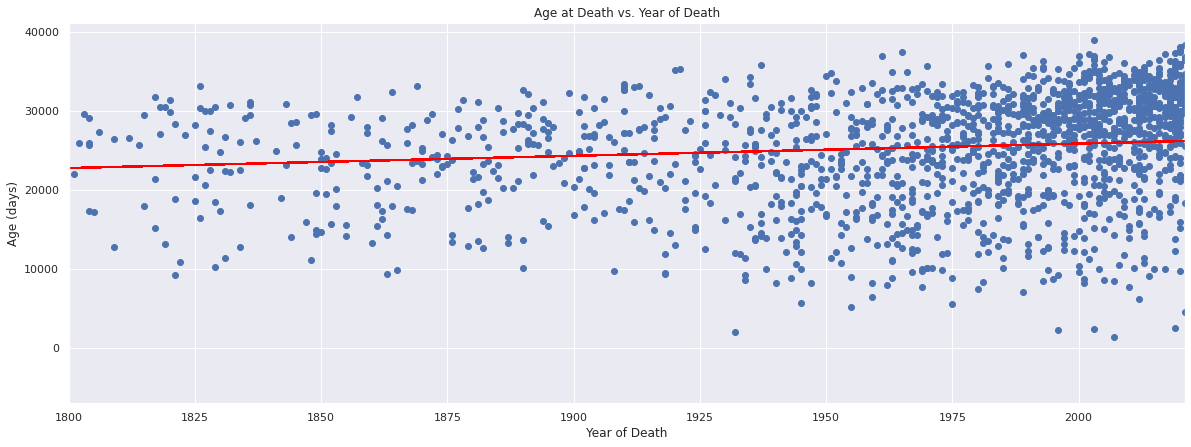

In [509]:
figAll, axAll = plt.subplots(figsize=(20,7))
# Plots age at death over year of death
axAll.scatter(x=data['Year of Death'], y=data['Age in Days'])
# Labels
axAll.set_xlabel("Year of Death")
axAll.set_ylabel("Age (days)")
axAll.set_title('Age at Death vs. Year of Death')
# Reducing the min cuts off a handfull points but drastically improves the plot
plt.xlim(1800, 2021)
# Plots the linear regression line using the'mymodel' array
plt.plot(ind, mymodel, color='red')
figAll.savefig('agevsyear.png')

Surprisingly, there does not appear to be much of a difference in terms of average celebrity life span from one year to the next. From the first tracked death in 19 AD to the present, there is only an increase of about 15 1/2 days per year. I would have expected the average life expectancy to rise a bit faster but I have a couple theories as to why it does not.

For one, the first tracked death, though cut off from the plot, was considered by the model. It occurred in 19 AD to Germanicus, the adopted son of the Emperor Tiberius. There was a significant amount of space between that death and the next one. I would like to see this model disregard points from before 1800 to see what sort of affect this has.

Secondly, I believe the definition of 'famous person' changes significantly around the start of the 20th century. Prior, while artists were definetly considered, I believe a lot of 'famous people' were more academic in nature and consequently were only able to achieve their fame by living long enough to become recognized, as such they are not representative of the population of that time period as they had to have longer lives to make the 'famous person' list and therefore lived longer than the average person who died before accomplishing much. This will be able to be seen by differentiating between occupations using color coding.

I will start by refining the data set to only include entries for people who died in 1800 or later. I believe entries before then to be unreliable at best anyway.

In [616]:
post1800 = pd.DataFrame(columns=data.columns)
# Iterates through 'data'
x = 0
for row in data.iterrows():
    # If year of death is 1800 or later
    if data.iloc[x,5] >= 1800:
        # Add it to 'post1800'
        ser = pd.Series([data.iloc[x,0], data.iloc[x,1], data.iloc[x,2], data.iloc[x,3],data.iloc[x,4],data.iloc[x,5]], index=data.columns)
        post1800 = post1800.append(ser, ignore_index=True)
    x += 1

As seen below by the removal of Germanicus, we now have a new DataFrame, 'post1800', that has all of the dead famous people from 'data' that died in 1800 or later.

In [679]:
print(len(data))
data.head()

1748


,Name,Occupation,Age at Death (Years),Days Since Last Birthday,Age in Days,Year of Death
0,Barbaro,Animal,3,275,1370,2007
1,Germanicus,Government Official,4,139,1600,19
2,Phar Lap,Animal,5,184,2010,1932
3,JonBenet Ramsey,Victim,6,141,2332,1996
4,Dolly the Sheep,Animal,6,224,2415,2003


In [680]:
print(len(post1800))
post1800.head()

1646


,Name,Occupation,Age at Death (Years),Days Since Last Birthday,Age in Days,Year of Death,residual,New Residuals
0,Barbaro,Animal,3,275,1370,2007,25190.3,-5779.74
1,Phar Lap,Animal,5,184,2010,1932,22130.5,330.693
2,JonBenet Ramsey,Victim,6,141,2332,1996,23873.4,-7478.41
3,Dolly the Sheep,Animal,6,224,2415,2003,24016.3,-4442.99
4,Grumpy Cat,Other,7,40,2596,2019,24351.5,-23616.3


I will now redo the linear regression model using the refined data set to see what kind of an effect was had.

In [619]:
# Two lists, from 'Year of Death' & 'Age in Days' for use creating a linear regression model
ind1800 = [i for i in post1800['Year of Death']]
dep1800 = [i for i in post1800['Age in Days']]

slope, intercept, r, p, std_err = stats.linregress(ind1800, dep1800)

mymodel = list(map(myfunc, ind1800))

# Prints out the variables created and used above.
print("Slope: " + str(slope) +\
     "\nY-Intercept: " + str(intercept) +\
     "\nR-Value: " + str(r) +\
     "\nP-Value: " + str(p) +\
     "\nStandard Error: " + str(std_err))

Slope: 32.26456573132938
Y-Intercept: -38194.657118935
R-Value: 0.23980151105772934
P-Value: 5.852232838711637e-23
Standard Error: 3.221532994802741


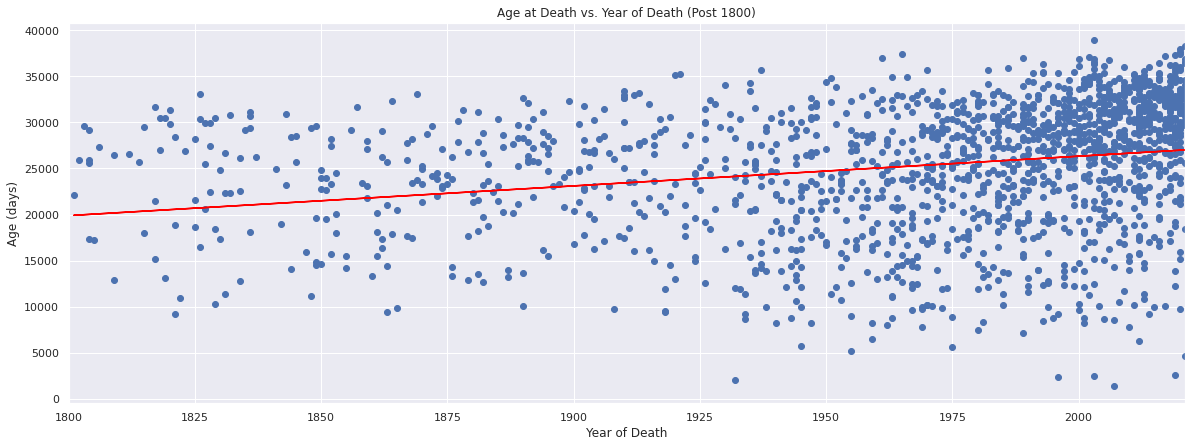

In [620]:
fig1800, ax1800 = plt.subplots(figsize=(20,7))

# Plots age at death over year of death
ax1800.scatter(x=post1800['Year of Death'], y=post1800['Age in Days'])
# Labels
ax1800.set_xlabel("Year of Death")
ax1800.set_ylabel("Age (days)")
ax1800.set_title('Age at Death vs. Year of Death (Post 1800)')
plt.xlim(1800, 2021)
# Plots the linear regression line using the'mymodel' array
plt.plot(ind1800, mymodel, color='red')
fig1800.savefig('agevsyearpost1800.png')

In [681]:
# Calculates the percentage of data lost by cutting off pre-1800 data points.
(len(data)-len(post1800)) / len(data) * 100

5.835240274599542

As shown, this refinment nearly doubled the rate at which the average life span increases per year. I do not find this surprising. For one, considering the advancments in modern medicine, the average life expectancy has risen significantly within the past 200 years. Second, by removing the tracked entries pre-1800, we only lost about 100 data points. However, we cut the recorded timeframe by close to 1800 years due to the first entry being from 19 AD. I do not take issue with doing this as that first entry was over a thousand years before the next entry so it was a pretty significant outliar that probably should not have been included in the first place.

Since we have a linear regression model, we can calculate each data point's residual to see how far off from the prediction it is. This is done by subtracting the actual 'Age in Days' from the predicted value in 'mymodel'. We will plot this at the start of the Machine Learning section to show whether or not the model worked.

In [626]:
post1800['residual'] = mymodel - post1800['Age in Days']
post1800.head()

,Name,Occupation,Age at Death (Years),Days Since Last Birthday,Age in Days,Year of Death,residual
0,Barbaro,Animal,3,275,1370,2007,25190.3
1,Phar Lap,Animal,5,184,2010,1932,22130.5
2,JonBenet Ramsey,Victim,6,141,2332,1996,23873.4
3,Dolly the Sheep,Animal,6,224,2415,2003,24016.3
4,Grumpy Cat,Other,7,40,2596,2019,24351.5


We have already seen how each occupation relates to the others. Now we want to break the data up by occupation to see what effect time has had on each occupation independent of the other occupations. We can do this by iterating through the unique 'Occupation' values, searching through 'post1800' for matching rows. Our end result is a list of DataFrames, each consisting of all the values for a specific occupation category.

In [629]:
occupations = sorted(post1800['Occupation'].unique())
separated = []

# For each unique occupation
for job in occupations:
    # Resets 'curr' to empty DataFrame
    curr = pd.DataFrame(columns=post1800.columns)
    # Iterates through 'post1800' searching for rows with 'Occupation' matching current 'job'
    x = 0
    for row in post1800.iterrows():
        # If 'Occupation' value matches current job
        if post1800.iloc[x,1] == job:
            # Creates a Series, 'ser' using data from current row
            ser = pd.Series([post1800.iloc[x,0], post1800.iloc[x,1], post1800.iloc[x,2], post1800.iloc[x,3],post1800.iloc[x,4],post1800.iloc[x,5], post1800.iloc[x,6]], index=post1800.columns)
            # Appends 'ser' to 'curr' DataFrame
            curr = curr.append(ser, ignore_index=True)
        x += 1
    # Adds 'curr' DataFrame to 'separated' list, creating a list of DataFrames
    separated.append(curr)

To make the DataFrames easier to work with, I assign them to variables with easy to understand names. I of course could access them directly from the list, but this would be unnecessarily hard to keep track of.

In [630]:
academics = separated[0]
activists = separated[1]
animals = separated[2]
artists = separated[3]
athletes = separated[4]
criminals = separated[5]
entertainers = separated[6]
governers = separated[7]
musicians =separated[8]
others = separated[9]
scientists = separated[10]
useless = separated[11]
victims = separated[12]
wars = separated[13]

Using seaborn, we can easily create a scatter plot that's been color coded by 'Occupation'. Besides the color coding, this plot is pretty much identical to the above scatter plot.

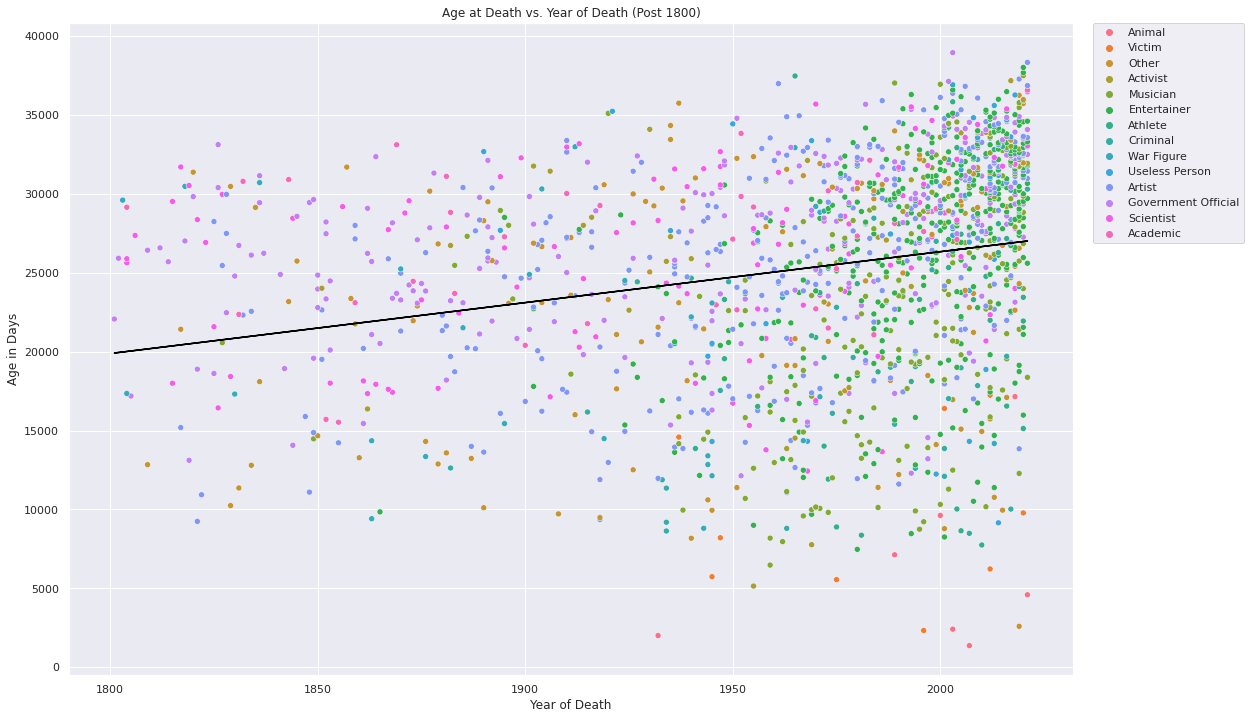

In [632]:
sns.set(rc={'figure.figsize':(18,12)})
test = sns.scatterplot(x=post1800['Year of Death'], y=post1800['Age in Days'], hue=post1800['Occupation']).set(title="Age at Death vs. Year of Death (Post 1800)")
# Plot linear regression line in black
plt.plot(ind1800, mymodel, color='black')
# Move legend off off plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig1800.savefig('agevsyearpost1800colorcoded.png')

We can now see that we were correct, the definition of 'famous person' has indeed changed over time, or rather broadened. Let's remove some of the less important categories from the scatter plot. This will help us see what the most prominent categories are without the noise. The categories we will be removing are "Animal", 'Victim', 'Other', and 'Useless Person'.

In [633]:
# New occupations list without the above mention categories
trimmedOccs = ['Academic', 'Activist', 'Artist', 'Athlete', 'Criminal', 'Entertainer', 'Government Official', 'Musician','Scientist','War Figure']

Iterates through 'post1800', only copying rows that have 'Occupation' values within the above 'trimmedOccs' list.

In [634]:
removed = pd.DataFrame( columns = post1800.columns)
# Iterates through trimmed down 'Occupation' categories
for job in trimmedOccs:
    # Iterates through 'post1800' pulling out 
    x = 0
    for row in post1800.iterrows():
        # If 'Occupation' matches current job
        if post1800.iloc[x,1] == job:
            ser = pd.Series([post1800.iloc[x,0], post1800.iloc[x,1], post1800.iloc[x,2], post1800.iloc[x,3],post1800.iloc[x,4],post1800.iloc[x,5], post1800.iloc[x,6]], index=post1800.columns)
            removed = removed.append(ser, ignore_index=True)
        x += 1

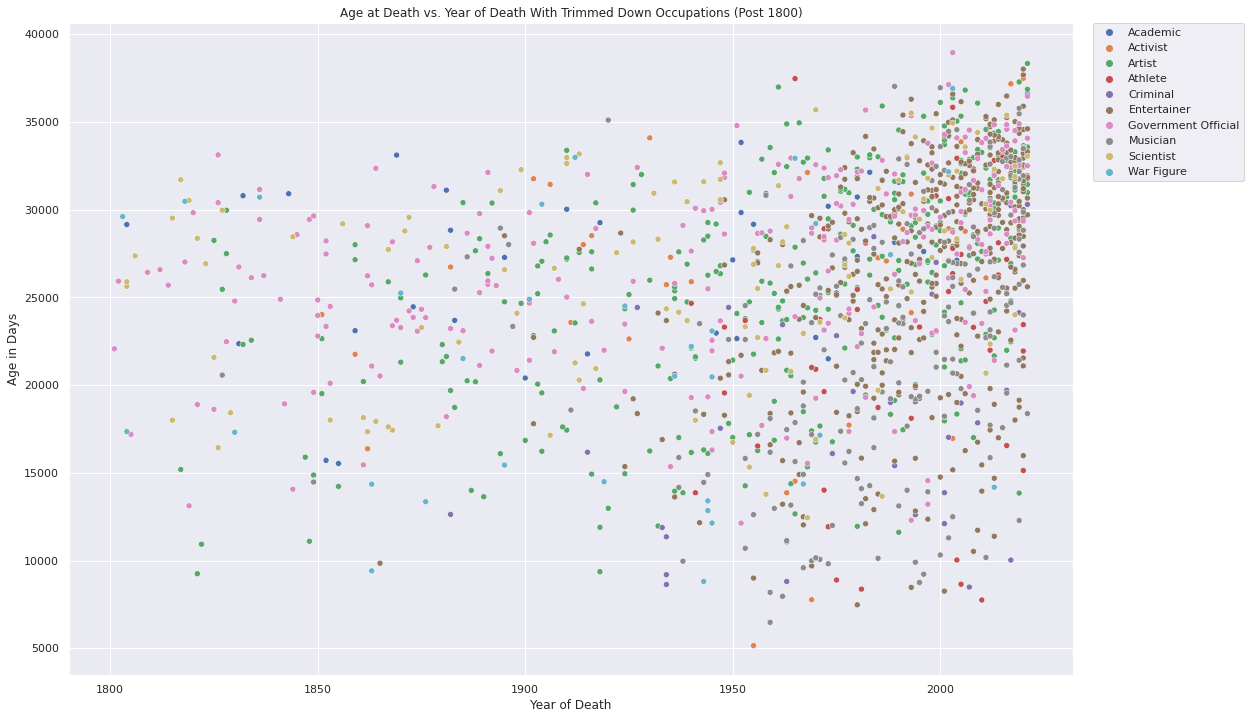

In [635]:
# Plots new DataFrame
trimmedPlot = sns.scatterplot(x=removed['Year of Death'], y=removed['Age in Days'], hue=removed['Occupation']).set(title="Age at Death vs. Year of Death With Trimmed Down Occupations (Post 1800)")
# Moves legend
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig1800.savefig('agevsyeartrimmedpost1800colorcoded.png')

With the trimmed down categories, it is becoming a bit easier to see that what it takes to become a 'famous person' definetly has changed over time. For example, in the easly 1800's, there are a lot of Government Officials and Scientists with a decent number of Academics and Artists in the mix. There are of course a few appearances by other categories but those are by far the most common. As time progresses, the density of famous people increases significantly. Most notably, around the 1950's we begin to see a much higher concentration of Entertainers and Musicians dying which aligns with what we know about popular culture and the rise of Rock & Roll and Hollywood. We of course continue to see Government Officials and Scientists but there does appear to be a decline in Artists and Academics. We will know conclusively if we pull the number of deathd of each for a given time period.

Through this data we can start to potentially see another interesting trend, that is the effect that popular culture has on the definition of 'famous'. It is clear that certain categories dominate specific time periods. It is also apparent that the closer to the modern age that we get, the higher the concentration of famous people there are. This is very likely a direct result of improvements in mass communication.

Lets compare the number of deaths seen for each year in total to the number of deaths seen for a couple of our occupation categories.

In [636]:
# Retuns the number of occurences each year has in the 'Year of Death' column of 'post1800'
occur = post1800.groupby(['Year of Death']).size()
# Turns Series into a DataFrame for plotting
allFrame = pd.DataFrame(occur)
allFrame = allFrame.reset_index()
allFrame['Year of Death'] = allFrame['Year of Death'].astype(int)

The plot below shows us the toal number of famous people that died each year. This helps us get an idea of the rate at which the number of famous people is increasing. As population rises it can be expected that the amount of famous people will also rise. However, this rate of increase exceeds the rate at which the <a href="https://www.macrotrends.net/countries/USA/united-states/population-growth-rate">US population</a> increases.

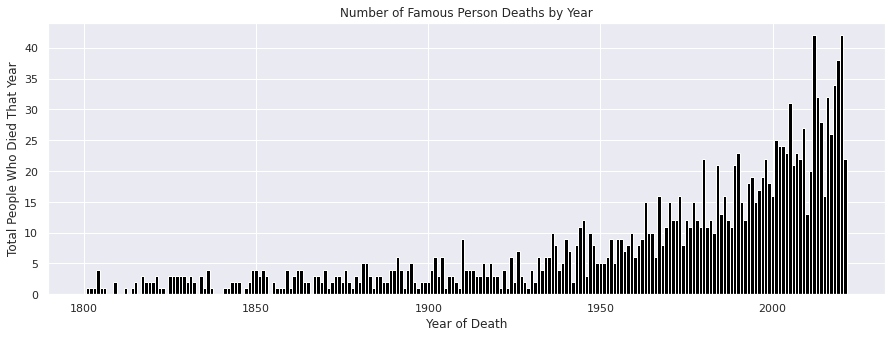

In [637]:
# Plot
figAll, axAll = plt.subplots(figsize=(15,5))
axAll.bar(allFrame['Year of Death'], allFrame[0], width=1, color='black')
axAll.set_xlabel('Year of Death')
axAll.set_ylabel('Total People Who Died That Year')
axAll.set_title('Number of Famous Person Deaths by Year')
figAll.show()

Let's look at a couple different occupations and see how they compare. The code used does exactly the same things as the above with the exception that it pulls from the DataFrames consisting of the sorted categories instead of 'post1800'.

In [638]:
occur = governers.groupby(['Year of Death']).size()
govFrame = pd.DataFrame(occur)
govFrame = govFrame.reset_index()
govFrame['Year of Death'] = govFrame['Year of Death'].astype(int)

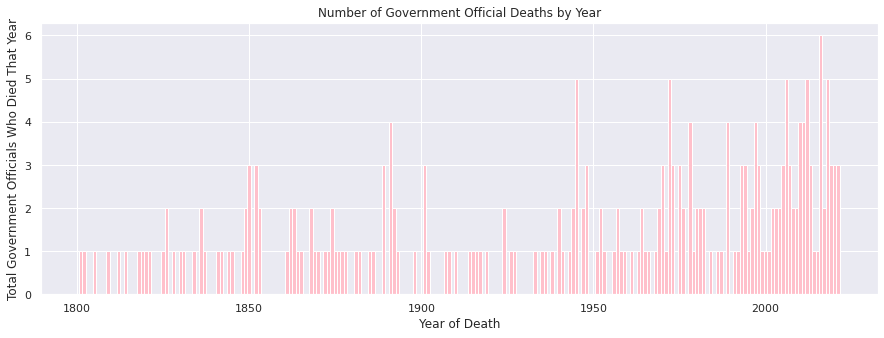

In [639]:
figGov, axGov = plt.subplots(figsize=(15,5))

axGov.bar(govFrame['Year of Death'], govFrame[0], width=1, color='pink')
axGov.set_xlabel('Year of Death')
axGov.set_ylabel('Total Government Officials Who Died That Year')
axGov.set_title('Number of Government Official Deaths by Year')
figGov.show()

In [640]:
occur = artists.groupby(['Year of Death']).size()
artFrame = pd.DataFrame(occur)
artFrame = artFrame.reset_index()
artFrame['Year of Death'] = artFrame['Year of Death'].astype(int)

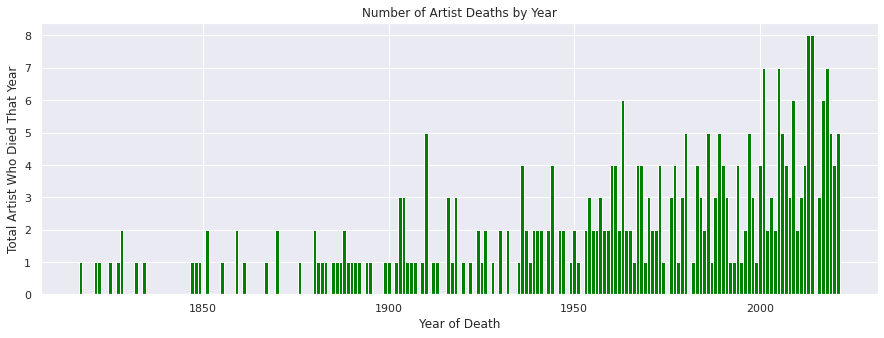

In [641]:
figArt, axArt = plt.subplots(figsize=(15,5))

axArt.bar(artFrame['Year of Death'], artFrame[0], width=1, color='green')
axArt.set_xlabel('Year of Death')
axArt.set_ylabel('Total Artist Who Died That Year')
axArt.set_title('Number of Artist Deaths by Year')
figArt.show()

In [642]:
occur = entertainers.groupby(['Year of Death']).size()
entFrame = pd.DataFrame(occur)
entFrame = entFrame.reset_index()
entFrame['Year of Death'] = entFrame['Year of Death'].astype(int)

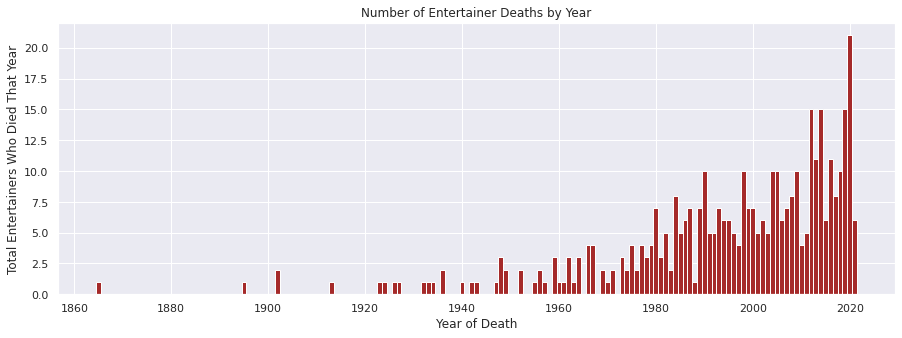

In [643]:
figEnt, axEnt = plt.subplots(figsize=(15,5))

axEnt.bar(entFrame['Year of Death'], entFrame[0], width=1, color='brown')
axEnt.set_xlabel('Year of Death')
axEnt.set_ylabel('Total Entertainers Who Died That Year')
axEnt.set_title('Number of Entertainer Deaths by Year')
figEnt.show()

In [644]:
occur = musicians.groupby(['Year of Death']).size()
musFrame = pd.DataFrame(occur)
musFrame = musFrame.reset_index()
musFrame['Year of Death'] = musFrame['Year of Death'].astype(int)

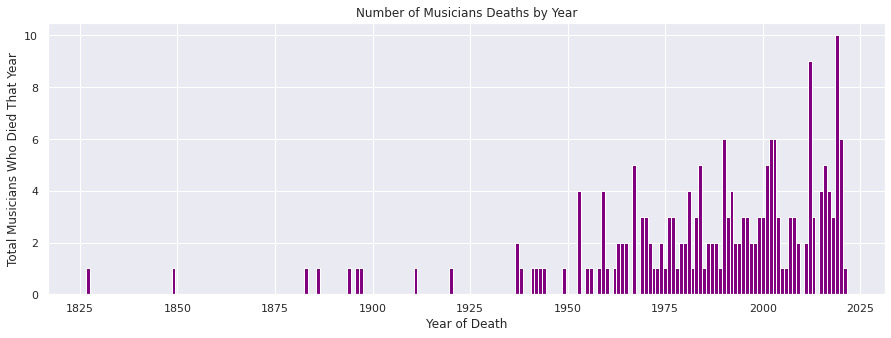

In [645]:
figMus, axMus = plt.subplots(figsize=(15,5))

axMus.bar(musFrame['Year of Death'], musFrame[0], width=1, color='purple')
axMus.set_xlabel('Year of Death')
axMus.set_ylabel('Total Musicians Who Died That Year')
axMus.set_title('Number of Musicians Deaths by Year')
figMus.show()

These four plots in combination with the 'Number of Famous Person Deaths by Year' plot proves exactly what we thought we were seeing on the scatter plot. That is, around the mid 1900's we began to see  deaths for musicians and entertainers at rates never before documented. This is expected as the decades immediatly prior were when music, television, and cinema began to take off so it makes sense that shortly after, the people who achieved fame in those industries early on would began to die. Conversly, we see that while artists and government officals also see a rise in death rates, their increases align much closer to the overall rise instead of just sharply spiking in modern times.

I believe that this suceeds in highlighting the differences in what it meant to be 'famous' (or at the very least renowned) hundreds of years ago versus now. Granted, that was not our initial goal, it is still interesting to make note of, especially since our initial goal (year of death vs age at death and eventually vs occupation) is not necessarily causation. It is good to point out a relationship that is; as time increases, the amount of famous people also increases.

## Part 4: Machine Learning

Now let's have some fun and attempt to build a predictive model. We will make a model that uses the year of death and occupation to predict the age of the person when they died. <b>Please note that this model is just for fun, it will not be realistic!</b> While some occupations may have slightly higher mortality rates, overall there is minimal relationship between the two and almost no relationship between year of death and age at death. Despite this we are going to see what our model can do based on the provided data. Use this as an example for how predictive models can draw false conclusions.

To start lets redo the violin plots that had the age ranges sorted by occupation. We will use the 'post1800' DataFrame instead of the full 'data' DataFrame. We can reuse the code from when we originally created the violin plot except now we pull from 'post1800' instead of 'data'.

In [646]:
# Creates an array consisting of the occupation options
occupations = sorted(post1800['Occupation'].unique())
# A new empty list
DeathsByOcc = []
# Iterates through the types of occupations
for job in occupations:
    # Resets 'curr' to an empty list
    curr = []
    # Iterates through the 'post1800' DataFrame
    x = 0
    for row in post1800.iterrows():
        # If current row's 'Occupation' matches the one being searched for
        if post1800.iloc[x,1] == job:
            # Add it to 'curr'
            curr.append(post1800.iloc[x,4])
        x += 1
    # Adds 'curr' to 'DeathsByOcc' creating a list of lists
    DeathsByOcc.append(curr)         

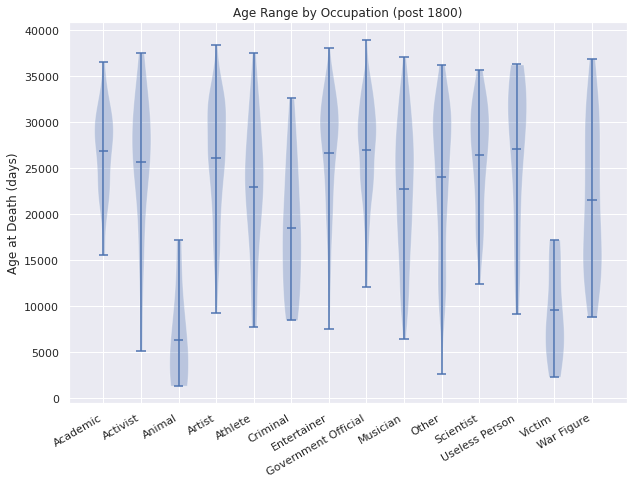

In [647]:
fig, ax = plt.subplots(figsize=(10,7))
# Create a violin plot
dic = ax.violinplot(DeathsByOcc, showmeans=True)
ax.set_ylabel("Age at Death (days)")
ax.set_title("Age Range by Occupation (post 1800)")
# Formatting for x labels
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ax.set_xticklabels(occupations)
plt.xticks(rotation=30, ha='right')
# Display plot
fig.show()

Now that we have the slightly adjusted violin plot we can create the residuals plot and compare it against the above to ensure it is what we expect. To do this we just collect the 'residuals' values from 'post1800' the same way we collected the 'Age in Days' values above.

In [650]:
# A new empty list
ResidualsByOcc = []
# Iterates through the types of occupations
for job in occupations:
    # Resets 'curr' to an empty list
    curr = []
    # Iterates through the 'post1800' DataFrame
    x = 0
    for row in post1800.iterrows():
        # If current row's 'Occupation' matches the one being searched for
        if post1800.iloc[x,1] == job:
            # Add it to 'curr'
            curr.append(post1800.iloc[x,6])
        x += 1
    # Adds 'curr' to 'DeathsByOcc' creating a list of lists
    ResidualsByOcc.append(curr)         

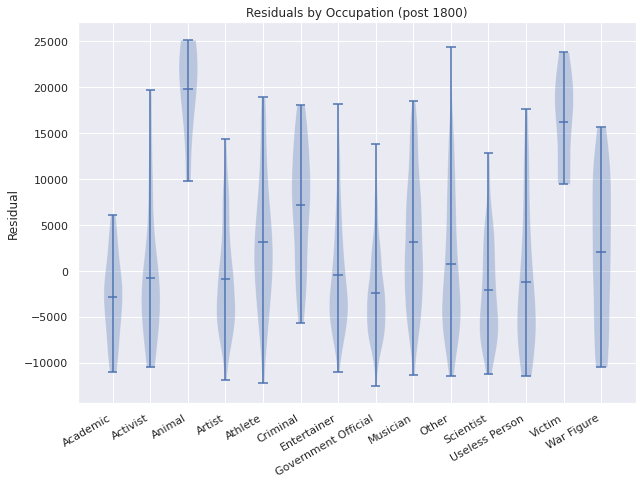

In [654]:
fig, ax = plt.subplots(figsize=(10,7))

# Create a violin plot
dic = ax.violinplot(ResidualsByOcc, showmeans=True)
ax.set_ylabel("Residual")
ax.set_title("Residuals by Occupation (post 1800)")
# Formatting for x labels
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ax.set_xticklabels(occupations)
plt.xticks(rotation=30, ha='right')
# Display plot
fig.show()

This looks just as expected. Since the residual is calculated by subtracting the actual value from th predicted value, the residual's plot will look like the age range at death plot but flipped horizontally. This is due to any actual values higher than the prediction returning negative residuals and any values lower than the prediction returning positive residuals. The prediction will not necessarily be the mean, but it should be close.

Now to train a model that takes two dependent variables.

In [590]:
# Creates a DataFrame pulling just the 'Age in Days' and 'Year of Death' columns from 'post1800'
stand = post1800[['Age in Days', 'Year of Death']].copy(deep=True)
stand.head()

,Age in Days,Year of Death
0,1370,2007
1,2010,1932
2,2332,1996
3,2415,2003
4,2596,2019


We need to create a new DataFrame with all the dummy values and then concat that to the above DataFrame. It will be this DataFrame that is fed into the fit() function to create the new model.

In [595]:
# Creates the dummies DataFrame with columns for all occupations except 'Academic'
cont_feat = pd.get_dummies(post1800['Occupation'], drop_first=True)

# Concats the above 'cont_feat' DataFrame to the 'stand' DataFrame
combined_feat = pd.concat([stand, cont_feat], axis=1)

# Creates an array consisting of the 'Occupation' values from 'post1800'
conts = post1800['Occupation'].values

# Adds the year columns to the 'combined_feat' DataFrame
for s in filter(lambda s: s != "Academic", conts):
    combined_feat['year'+s] = combined_feat[s]*combined_feat['Year of Death']

combined_feat.head()

,Age in Days,Year of Death,Activist,Animal,Artist,Athlete,Criminal,Entertainer,Government Official,Musician,Other,Scientist,Useless Person,Victim,War Figure,yearAnimal,yearVictim,yearOther,yearActivist,yearMusician,yearEntertainer,yearAthlete,yearCriminal,yearWar Figure,yearUseless Person,yearArtist,yearGovernment Official,yearScientist
0,1370,2007,0,1,0,0,0,0,0,0,0,0,0,0,0,2007,0,0,0,0,0,0,0,0,0,0,0,0
1,2010,1932,0,1,0,0,0,0,0,0,0,0,0,0,0,1932,0,0,0,0,0,0,0,0,0,0,0,0
2,2332,1996,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1996,0,0,0,0,0,0,0,0,0,0,0
3,2415,2003,0,1,0,0,0,0,0,0,0,0,0,0,0,2003,0,0,0,0,0,0,0,0,0,0,0,0
4,2596,2019,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2019,0,0,0,0,0,0,0,0,0,0


Using the above DataFrame, we create a new variable, 'X', that is everything except the 'Age in Days' column. This variable will act as the independent variable when creating the model. Another variable, 'y' is just the 'Age in Days' column as it will act as the dependent variable.

In [596]:
# Independent variables, years and continents
X = combined_feat.drop('Age in Days', axis=1)
# Dependent variable, 'lifeExp'
y = combined_feat['Age in Days']

# Creates a new linear regression model, taking into consideration the extra independent variable
lr = linear_model.LinearRegression()
lr.fit(X,y)

LinearRegression()

We can print out the intercept and coefficients of the predictive equation. Each of the below parameters are multiplied with their associated value in the above DataFrame. As most of the values are 0, most of these parameters will not be considered. It is only when a field has a value other than 0 that the parameter is taken into consideration when calculating the prediction.

In [597]:
# Print out the parameters of the new linear regression model
print(lr.intercept_)
print(lr.coef_)

-13024.876385222415
[ 2.06782582e+01 -3.09420024e+04 -1.26214199e+05 -7.87415904e+04
 -1.07637373e+05 -1.08856055e+05 -1.80717917e+05 -1.83158177e+04
 -1.10829932e+05 -2.72994246e+04 -9.96065520e+03  1.27151070e+04
 -1.44799960e+04  2.25093307e+04  5.22608636e+01 -1.98322587e+00
  1.22769617e+01  1.49170478e+01  5.31060395e+01  8.97965365e+01
  5.14047394e+01  5.02555223e+01 -1.43806673e+01 -6.87045831e+00
  3.93535837e+01  9.28757091e+00  4.83001459e+00]


In [598]:
# Fills in the 'Prediction' & 'Residual' coulmns in 'combined_feat' using the new model
combined_feat['Prediction'] = lr.predict(X)
combined_feat['Residual'] = combined_feat['Age in Days'] - combined_feat['Prediction']
combined_feat.head(5)

,Age in Days,Year of Death,Activist,Animal,Artist,Athlete,Criminal,Entertainer,Government Official,Musician,Other,Scientist,Useless Person,Victim,War Figure,yearAnimal,yearVictim,yearOther,yearActivist,yearMusician,yearEntertainer,yearAthlete,yearCriminal,yearWar Figure,yearUseless Person,yearArtist,yearGovernment Official,yearScientist,Prediction,Residual
0,1370,2007,0,1,0,0,0,0,0,0,0,0,0,0,0,2007,0,0,0,0,0,0,0,0,0,0,0,0,7149.741517,-5779.74
1,2010,1932,0,1,0,0,0,0,0,0,0,0,0,0,0,1932,0,0,0,0,0,0,0,0,0,0,0,0,1679.307385,330.693
2,2332,1996,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1996,0,0,0,0,0,0,0,0,0,0,0,9810.412094,-7478.41
3,2415,2003,0,1,0,0,0,0,0,0,0,0,0,0,0,2003,0,0,0,0,0,0,0,0,0,0,0,0,6857.985030,-4442.99
4,2596,2019,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2019,0,0,0,0,0,0,0,0,0,0,26212.287919,-23616.3


In [661]:
post1800['New Residuals'] = combined_feat['Residual']
post1800.head()

,Name,Occupation,Age at Death (Years),Days Since Last Birthday,Age in Days,Year of Death,residual,New Residuals
0,Barbaro,Animal,3,275,1370,2007,25190.3,-5779.74
1,Phar Lap,Animal,5,184,2010,1932,22130.5,330.693
2,JonBenet Ramsey,Victim,6,141,2332,1996,23873.4,-7478.41
3,Dolly the Sheep,Animal,6,224,2415,2003,24016.3,-4442.99
4,Grumpy Cat,Other,7,40,2596,2019,24351.5,-23616.3


Plotting the new residuals.

In [662]:
# A new empty list
residual_per_year = []
# Iterates through the types of occupations
for job in occupations:
    # Resets 'curr' to an empty list
    curr = []
    # Iterates through the 'post1800' DataFrame
    x = 0
    for row in post1800.iterrows():
        # If current row's 'Occupation' matches the one being searched for
        if post1800.iloc[x,1] == job:
            # Add it to 'curr'
            curr.append(post1800.iloc[x,7])
        x += 1
    # Adds 'curr' to 'residual_per_year' creating a list of lists
    residual_per_year.append(curr)         

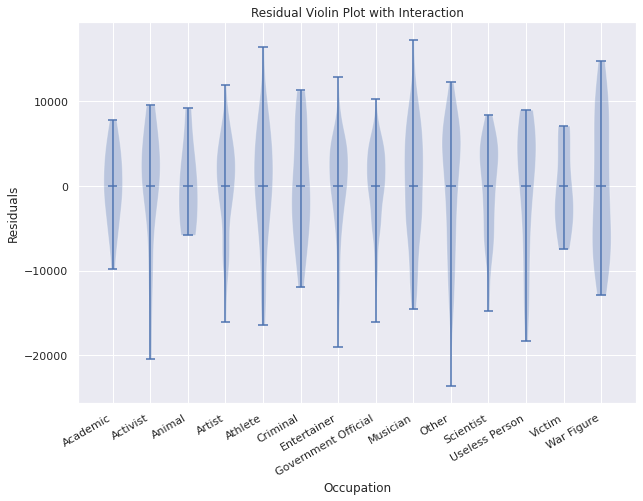

In [668]:
figRes, axRes = plt.subplots(figsize=(10,7))

axRes.violinplot(residual_per_year, showmeans=True)
# Formatting
axRes.set_xlabel("Occupation")
axRes.set_ylabel("Residuals")
axRes.set_title("Residual Violin Plot with Interaction")
# Formatting for x labels
axRes.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
axRes.set_xticklabels(occupations)
plt.xticks(rotation=30, ha='right')
figRes.show()

This is perfect. The distributions are either unimodal or close to it, with means very close to 0. This shows that our model did a good job compensating for the differences in occupation when calculating its predictions. The predicted values were much closer to the actual values resulting in the residuals being much more stable. There are clearly still some outliars but we cannot expect perfect predictions with a model as rough as the one used.

## Part 5: Conclusion

As I have reiterated multiple times, this model cannot accurately predict age of death. I doubt any model can, esspecailly one only taking 2 variables into consideration. This model was just able to do a decent job with the provided data set. Any new values added to the data set that happen to be close to the prediction are either entirely coincidental are are close due to other hidden influences.

Seeing as my original goal was to see if celebrities or rather 'famous people' were accurate representations of the general population, I think I actually accomplished it. We were able to show that no they are not, esspecially the further back in time you go. This is due to the requirements that being famous used to have which is that you generally either had to make significant contributions to science, art, or academia or you had to be a government official. All of these generally required lifetimes of work which resulted in most famous people being older as they had to have survived long enough to make a contribution.

What I found more interesting than my initial hypothesis was the rate at which the number of famous people increased, likely due to technological advancments that allowed for mass communication and resulted in popular culture. This could be interesting to explore further, maybe with a data set other than the famous people's times of death. I'm sure <a href="https://www.galbithink.org/ad-spending.htm">datasets tracking advertising revenue</a> would reflect these changes. Additionally, money spent on <a href="https://www.statista.com/chart/17244/us-music-revenue-by-format/">music</a>, <a href="https://www.statista.com/topics/964/film/">movies</a>, and other entertainment productes etc. Basically, just follow the money.

To recap, we can see that occupation is not meaningless when it comes to the age of death, at least in the data set used. However, it is not fool proof as seen on the residuals plot with the interaction; there were still mins and maxes all over the place. Additionally, as time increased so did the average life span, although this was expected as it is a known fact that our average life span as a species has been going up over time. I would have liked to have brought in cause of death and seen what relationships we could have found there but unfortunately the website used did not have an easy way to do this as a lot of the entries simply did not have cause of death listed. 